# Preproccesing-2

In [1]:
#### Imports ####
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import imshow, show, subplot,title,axis
from matplotlib.patches import Circle
from skimage.io import imread
from skimage import img_as_float,img_as_ubyte
from skimage.color import rgb2hsv,hsv2rgb,rgb2gray
import skimage.util
import skimage as sk
import scipy
import scipy.ndimage
import scipy.signal
import scipy.signal as signal
from scipy.signal import convolve,gaussian
from scipy.signal import convolve2d
from timeit import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import ndimage
import matplotlib.patches as patches
import os

c:\Users\dimea\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Features:
1) Area 
2) Area field
3) Area bbox
4) Extend
5) Euler number
6) Mean intensity 
7) Solidity
8) (Area filed - Area) / Area field

### Read images into a list

In [14]:
def load_images_from_folder(folder_path):
    """
    Load all images from the specified folder and return them as a list of images read by OpenCV.
    """
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = imread(image_path)
        if img is not None:
            images.append(img)
        else:
            print(f"Error loading image {filename}")
    return images

path_ctrl = r"C:\Users\dimea\OneDrive\Documents\University Courses\B.4 Applied Machine Learning\Final project\control-images"
path_pntr = r"C:\Users\dimea\OneDrive\Documents\University Courses\B.4 Applied Machine Learning\Final project\penetrax-images"
ctrl_im = load_images_from_folder(path_ctrl)
pntr_im = load_images_from_folder(path_pntr)

### Apply exposure.equalize_adapthist to images

In [15]:
ctrl_en_im= []
pntr_en_im= []
for i in ctrl_im:
    ctrl_en_im.append(skimage.exposure.equalize_adapthist(i, kernel_size=50, clip_limit=0.5, nbins=512))
for i in pntr_im:
    pntr_en_im.append(skimage.exposure.equalize_adapthist(i, kernel_size=50, clip_limit=0.5, nbins=512))

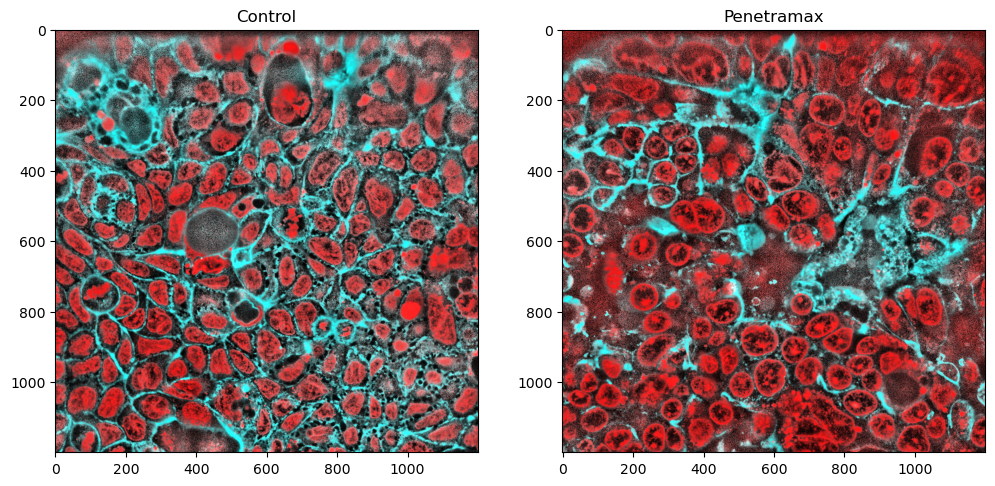

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Control')
plt.imshow(ctrl_en_im[0])
plt.subplot(1, 2, 2)
plt.title('Penetramax')
plt.imshow(pntr_en_im[0])
plt.show()

### Cell pose

In [18]:
from cellpose import models

def mask(image,diameter=50,channels=[1,0]):
    masks, flows, styles = models.CellposeModel(model_type='nuclei').eval(image,
                            diameter=diameter, channels=channels)
    return masks

In [19]:
ctrl_mask_list = []
pntr_mask_list = []
for i,j in zip(ctrl_en_im,pntr_en_im):
    ctrl_mask_list.append(mask(i,60))
    pntr_mask_list.append(mask(j,60))

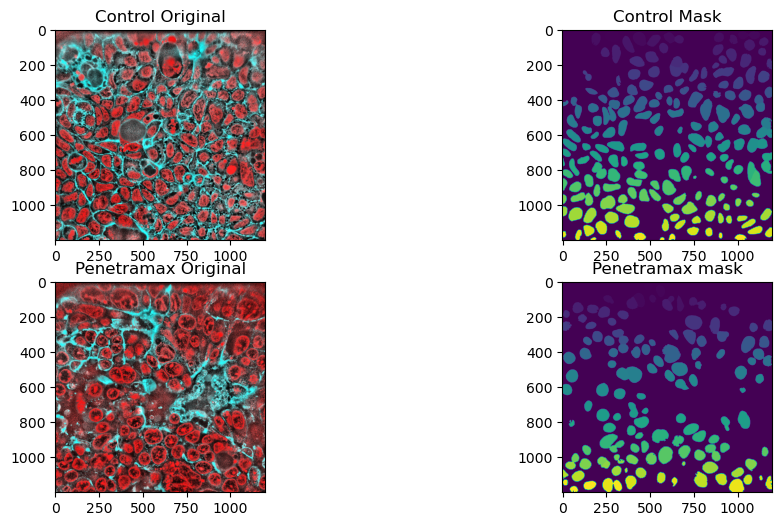

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title('Control Original')
plt.imshow(ctrl_en_im[0])

plt.subplot(2, 2, 2)
plt.title('Control Mask')
plt.imshow(ctrl_mask_list[0])

plt.subplot(2, 2, 3)
plt.title('Penetramax Original')
plt.imshow(pntr_en_im[0])

plt.subplot(2, 2, 4)
plt.title('Penetramax mask')
plt.imshow(pntr_mask_list[0])
plt.tight_layout
plt.show()

### Visualize the segmentation on top of the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


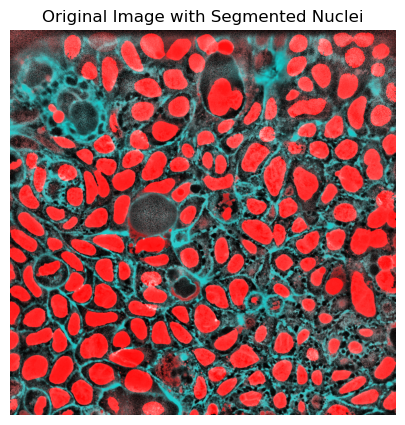

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


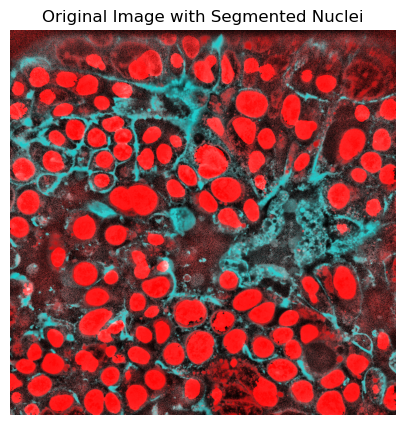

In [26]:
import cv2
def ontop(image,mask):
    masks_rgb = np.zeros_like(image)
    masks_rgb[:, :, 0] = mask

    alpha = 0.2  # Adjust transparency here
    overlay = cv2.addWeighted(image, 1 - alpha, masks_rgb, alpha, 0)
    # Display the original image with masks overlay
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay)
    plt.title('Original Image with Segmented Nuclei')
    plt.axis('off')
    plt.show()

ontop(ctrl_en_im[0],ctrl_mask_list[0])
ontop(pntr_en_im[0],pntr_mask_list[0])

### Substract each nuclei

In [37]:
from skimage import measure

labels,number = measure.label(pntr_mask_list[1], background=0, return_num=True, connectivity=2)
print(number)

151


In [45]:
import numpy as np
from skimage import io, img_as_ubyte

def pad_image_to_threshold(image, threshold=156):
    """
    Pads an image to the specified threshold dimensions with black pixels.

    :param image_path: Path to the input image.
    :param threshold: Desired dimensions (threshold, threshold) to pad the image to.
    :return: Padded image with dimensions (threshold, threshold).
    """
    
    # Get the current dimensions of the image
    height, width = image.shape[:2]
    
    # Check if the current dimensions are less than the threshold
    if width > threshold or height > threshold:
        raise ValueError("The image dimensions are already larger than the threshold.")
    
    # Create a new black image with the desired dimensions
    if image.ndim == 2:  # Grayscale image
        padded_image = np.zeros((threshold, threshold), dtype=image.dtype)
    else:  # Color image
        padded_image = np.zeros((threshold, threshold, image.shape[2]), dtype=image.dtype)
    
    # Calculate the position to place the original image in the center
    x_offset = (threshold - width) // 2
    y_offset = (threshold - height) // 2
    
    # Place the original image in the center of the new black image
    padded_image[y_offset:y_offset+height, x_offset:x_offset+width] = image
    
    return img_as_ubyte(padded_image)

## Get all images into a list

In [46]:
def get_larger_image(ctrl_masks,pntr_masks):
    ctrl_temp = []
    pntr_temp = []
    for k,i in enumerate(ctrl_masks):
        regions = measure.regionprops(i)
        for j,reg in enumerate(regions):
            bi_mask = reg.image
            ctrl_temp.append(bi_mask.shape)
    for k,i in enumerate(pntr_masks):
        regions = measure.regionprops(i)
        for j,reg in enumerate(regions):
            bi_mask = reg.image
            pntr_temp.append(bi_mask.shape)
    # Convert lists to numpy arrays for easier max computation
    ctrl_temp = np.array(ctrl_temp)
    pntr_temp = np.array(pntr_temp)
    
    # Find the maximum dimension in both control and pointer masks
    max_ctrl = np.max(ctrl_temp, axis=0)
    max_pntr = np.max(pntr_temp, axis=0)
    
    # Return the largest dimension from both sets
    return np.max([max_ctrl, max_pntr])

largest_dimention = get_larger_image(ctrl_mask_list,pntr_mask_list)
print(largest_dimention)

156


In [49]:
def get_cells(image_list,mask_list):
    temp = []
    for k,i in enumerate(mask_list):
        regions = measure.regionprops(i)
        for j,reg in enumerate(regions):
            min_row, min_col, max_row, max_col = reg.bbox

            region_of_interest = image_list[k][min_row:max_row,min_col:max_col]

            temp.append(pad_image_to_threshold(region_of_interest,156))
    return temp

ctrl_cell_images  = get_cells(ctrl_en_im,ctrl_mask_list)
pntr_cell_images  = get_cells(pntr_en_im,pntr_mask_list)

In [50]:
print("Number of control cells:",len(ctrl_cell_images))
print("Number of affected cells:",len(pntr_cell_images))

Number of control cells: 1336
Number of affected cells: 1494
